In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

(32, 256, 256, 3)
[0 1 0 0 2 0 0 0 1 2 0 0 1 1 2 1 0 1 0 1 0 0 2 1 1 2 0 1 1 1 0 0]


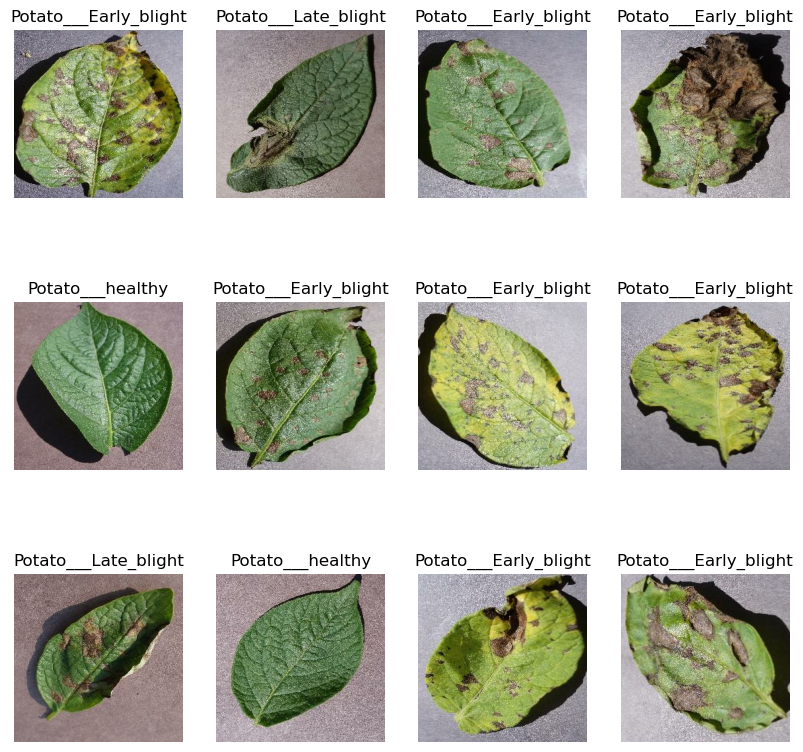

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

40 13 15


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
40/40 [==============================] - 53s 1s/step - loss: 0.9233 - accuracy: 0.4766 - val_loss: 0.8661 - val_accuracy: 0.4327
Epoch 2/20
40/40 [==============================] - 52s 1s/step - loss: 0.7813 - accuracy: 0.5922 - val_loss: 0.5037 - val_accuracy: 0.7764
Epoch 3/20
40/40 [==============================] - 52s 1s/step - loss: 0.5811 - accuracy: 0.7367 - val_loss: 0.3906 - val_accuracy: 0.8317
Epoch 4/20
40/40 [==============================] - 52s 1s/step - loss: 0.4976 - accuracy: 0.7781 - val_loss: 0.3056 - val_accuracy: 0.8750
Epoch 5/20
40/40 [==============================] - 53s 1s/step - loss: 0.3444 - accuracy: 0.8586 - val_loss: 0.2227 - val_accuracy: 0.9231
Epoch 6/20
40/40 [==============================] - 55s 1s/step - loss: 0.3134 - accuracy: 0.8711 - val_loss: 0.2109 - val_accuracy: 0.9207
Epoch 7/20
40/40 [==============================] - 55s 1s/step - loss: 0.2350 - accuracy: 0.9055 - val_loss: 0.2408 - val_accuracy: 0.9135
Epoch 8/20
40/40 [==

In [13]:
scores=model.evaluate(test_ds)
scores

15/15 [==============================] - 4s 233ms/step - loss: 0.0922 - accuracy: 0.9604


[0.09218290448188782, 0.9604166746139526]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.9233490228652954,
 0.7813048362731934,
 0.5810970664024353,
 0.4976486563682556,
 0.34435346722602844,
 0.3133619725704193,
 0.23498380184173584,
 0.26970481872558594,
 0.23850210011005402,
 0.24684159457683563,
 0.22583243250846863,
 0.24399912357330322,
 0.1914745420217514,
 0.15774935483932495,
 0.19379553198814392,
 0.17819979786872864,
 0.1490623652935028,
 0.15068474411964417,
 0.12818805873394012,
 0.1151413694024086]

In [16]:
history.history['accuracy']

[0.4765625,
 0.5921875238418579,
 0.7367187738418579,
 0.778124988079071,
 0.858593761920929,
 0.87109375,
 0.905468761920929,
 0.8921874761581421,
 0.909375011920929,
 0.9039062261581421,
 0.8999999761581421,
 0.9007812738418579,
 0.922656238079071,
 0.942187488079071,
 0.918749988079071,
 0.9242187738418579,
 0.946093738079071,
 0.9437500238418579,
 0.949999988079071,
 0.95703125]

In [17]:
history.history['val_loss']

[0.8660693764686584,
 0.5036523938179016,
 0.39058923721313477,
 0.30562907457351685,
 0.22274167835712433,
 0.2108607143163681,
 0.2407819926738739,
 0.16297565400600433,
 0.1626453548669815,
 0.24107028543949127,
 0.11991587281227112,
 0.17486634850502014,
 0.09828906506299973,
 0.16157501935958862,
 0.10244536399841309,
 0.11334796249866486,
 0.1900688260793686,
 0.06861074268817902,
 0.057420335710048676,
 0.05725180730223656]

In [18]:
history.history['val_accuracy']

[0.4326923191547394,
 0.776442289352417,
 0.8317307829856873,
 0.875,
 0.9230769276618958,
 0.9206730723381042,
 0.9134615659713745,
 0.9182692170143127,
 0.942307710647583,
 0.8966346383094788,
 0.963942289352417,
 0.932692289352417,
 0.9615384340286255,
 0.9350961446762085,
 0.9663461446762085,
 0.9567307829856873,
 0.901442289352417,
 0.9783653616905212,
 0.9807692170143127,
 0.9807692170143127]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

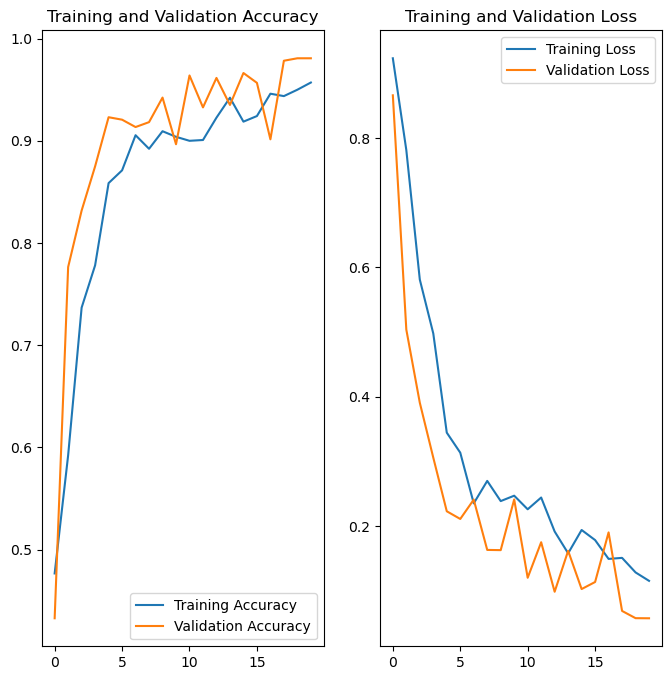

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(15):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 308ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


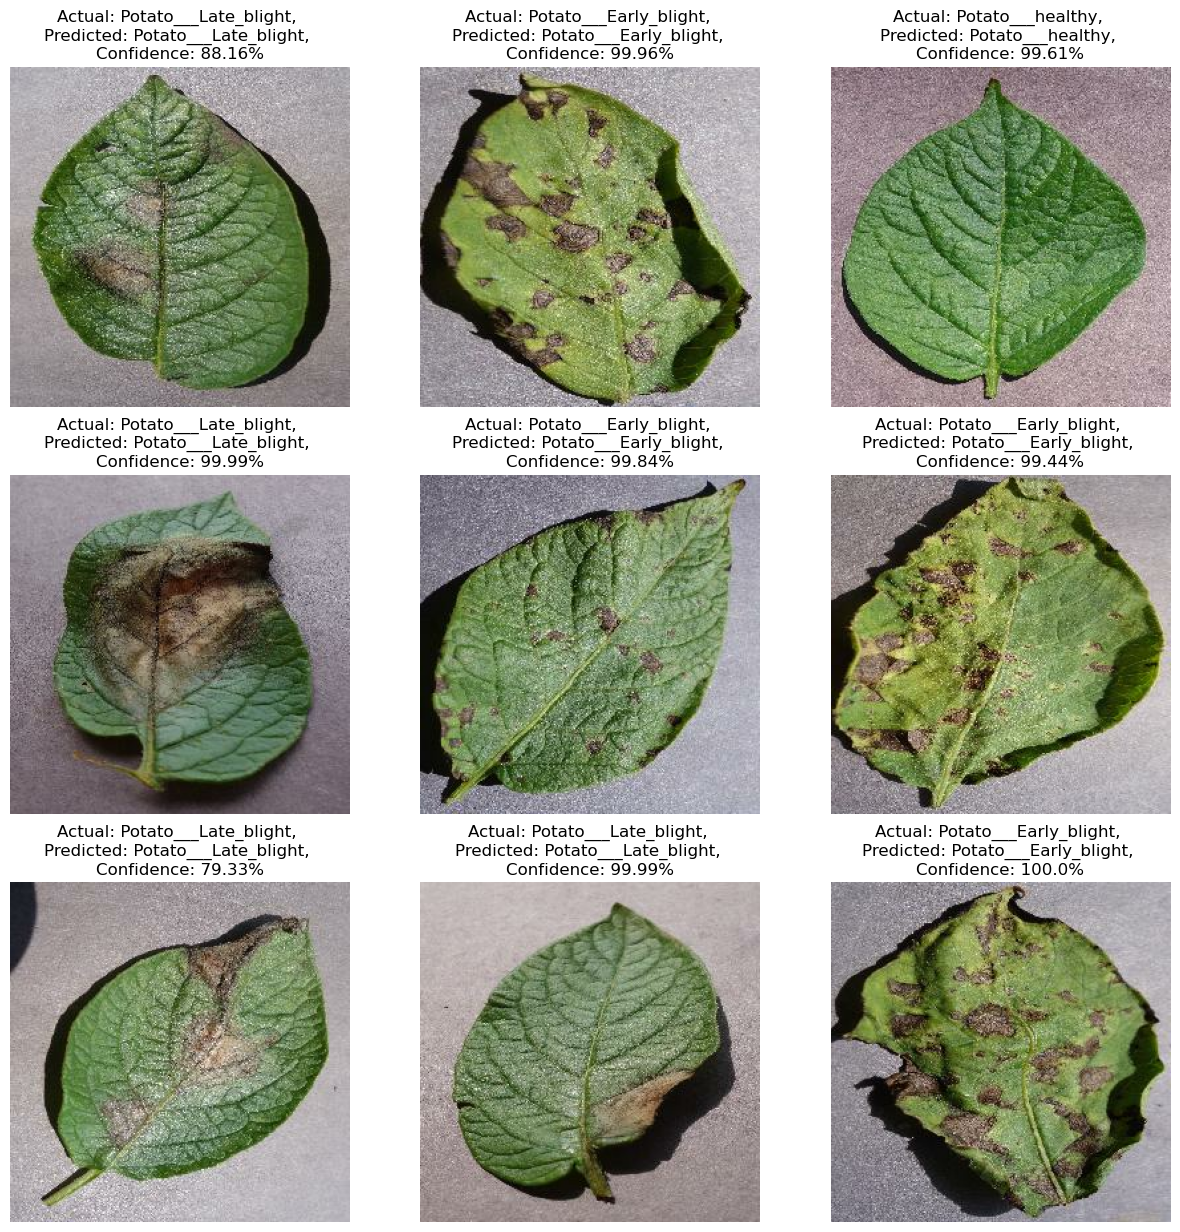

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       209
           1       0.97      0.95      0.96       238
           2       0.82      0.94      0.87        33

    accuracy                           0.96       480
   macro avg       0.92      0.95      0.94       480
weighted avg       0.96      0.96      0.96       480



In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[203,   6,   0],
       [  4, 227,   7],
       [  0,   2,  31]])>

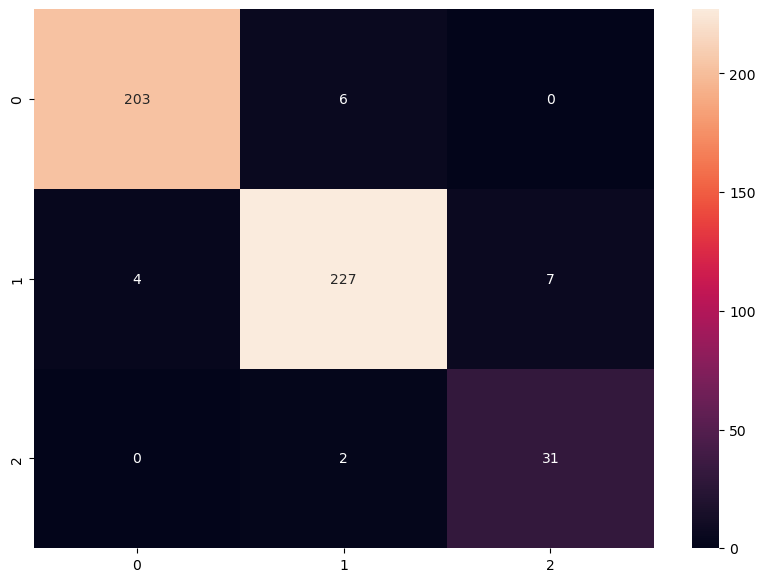

In [26]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [27]:
filename = "Model1-DatasetSplit60-20-20.joblib"
joblib.dump(model, filename)

['Model1-DatasetSplit60-20-20.joblib']